# Video

In ByoTrack videos are expected to be Sequences of frames. Currently only 2D frames are supported but this may change in the future.

We use numpy to represent frames: each frame is a numpy array of shape (H, W, C). The data type can be floating or integer but most of the codes of ByoTrack will expect the frames to be normalized into [0, 1] and we strongly advise to normalize videos.

ByoTrack have its own Video object (*byotrack.Video*) that enables you to read, slice and normalize videos without loading the full video in RAM. In this notebok, we explain how to read, slice, normalize and visualize such Video object in ByoTrack.

**NOTE**: In ByoTrack, the Video object can always be directly replaced by a 4D array (T, H ,W, C) or a Sequence of array [(H, W, C), ...].

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import byotrack
import byotrack.visualize

## Loading videos

A Video can be loaded from a single file (typically mp4 or avi). We support standard format (All those supported by OpenCV) and TIFF stacks.

Loading videos from multiple files (one file by frame) is not supported yet. The reading of such files should be done manually and then provided to ByoTrack as a Sequence of frames


In [2]:
# Loading a video from a file:

video = byotrack.Video("path/to/video.ext")

print("Video shape: T={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=250, H=1024, W=1024, C=1


In [3]:
# You can also load example videos provided by ByoTrack (See `byotrack.example_data`)
# Videos are downloaded in a user data folder and then read.

import byotrack.example_data

video = byotrack.example_data.hydra_neurons()

print("Video shape: T={}, H={}, W={}, C={}".format(*video.shape, video.channels))

Video shape: T=1000, H=848, W=1024, C=3


In [4]:
# Let's see the frame shape and dtype

print(video[0].shape, video[0].dtype)

(848, 1024, 3) uint8


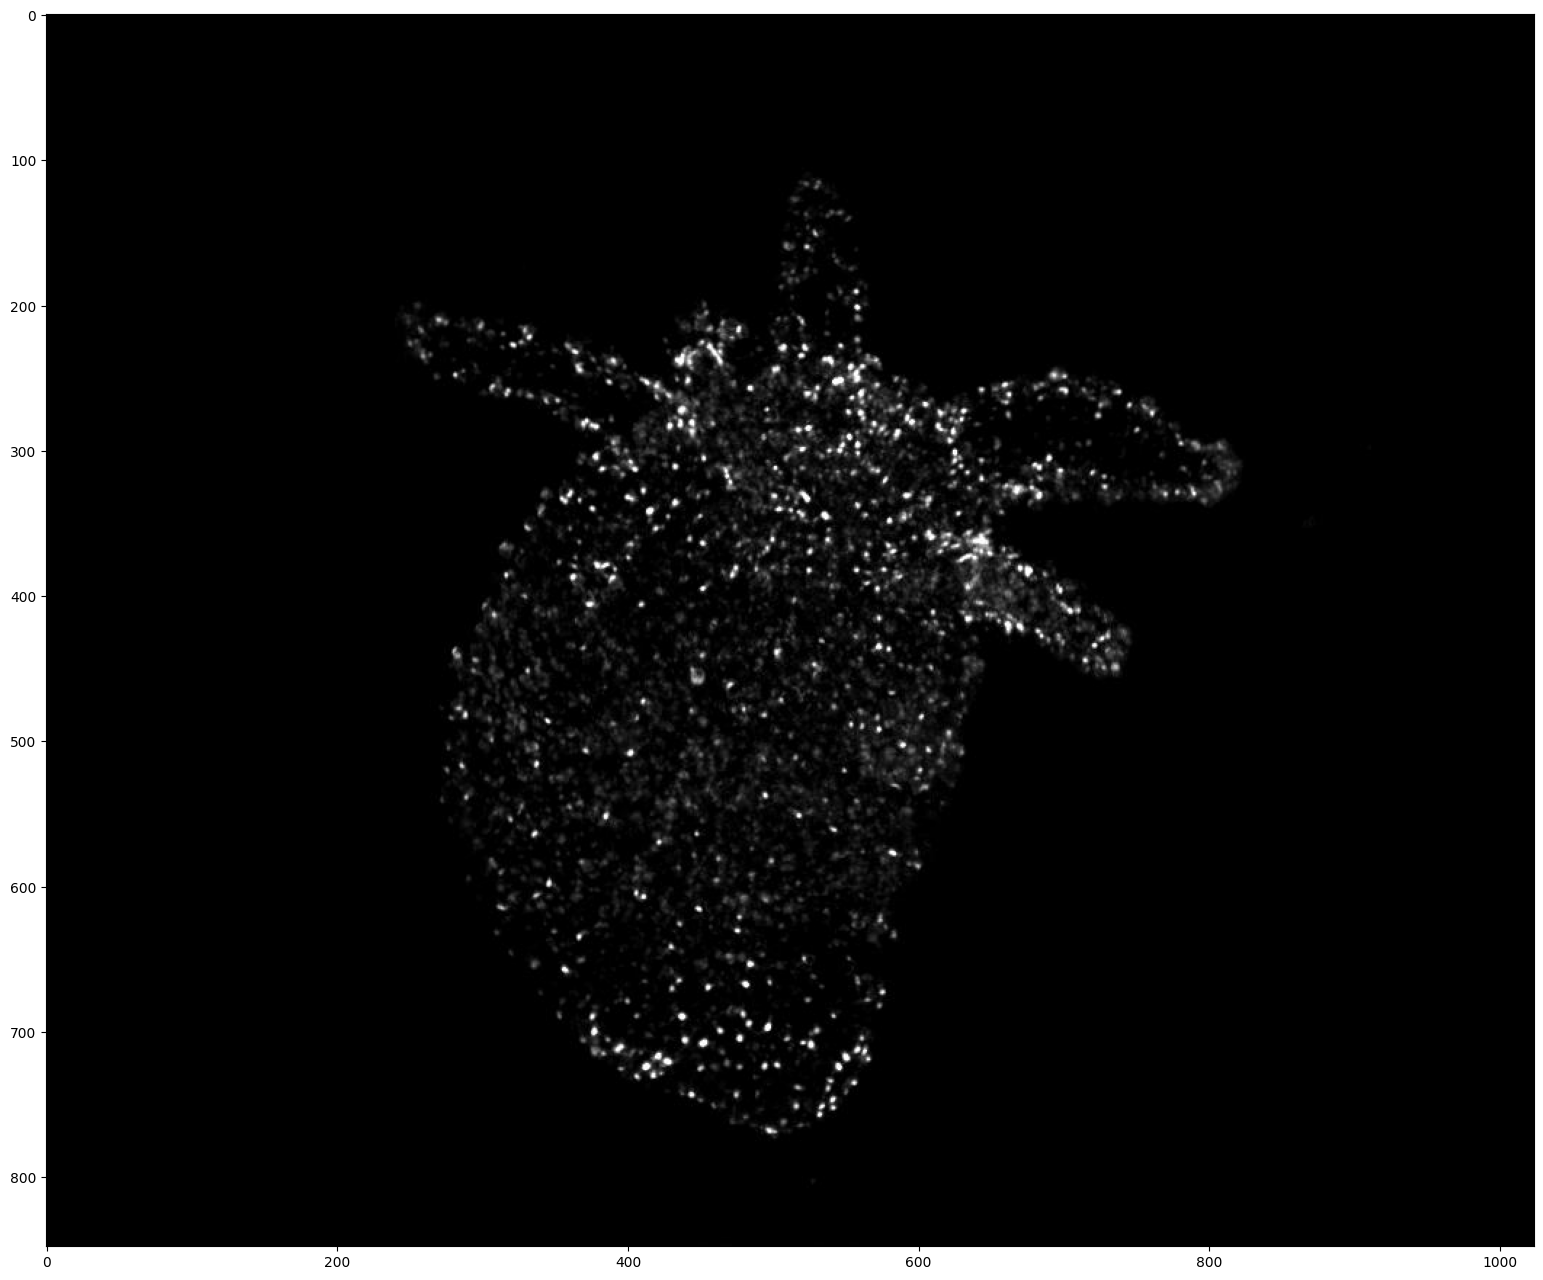

In [5]:
# Display the first frame of a video.
# This may not work for uint16 videos where normalization should be apply before visualization

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(video[0])
plt.show()

## Channel Selection / Normalization

ByoTrack provide some helpers to select and normalize channels in Video objects. It is done on the fly (when frames are required) and it never loads the full video at once.

If your video is not a byotrack.Video but a sequence of arrays (or directly a 4D array), you have to handle normalization on your own.

In [6]:
# See the doc of the Video transformation configuration

byotrack.VideoTransformConfig?

In [7]:
# Define the VideoTransformConfig

transform = byotrack.VideoTransformConfig(
    aggregate=True,  # Aggregate channels into a single one
    normalize=True,  # Normalize the video into [0, 1]
    selected_channel=None,  # None: Average channels, if int, it selects this channel
    q_min=0.02,  # We do not normalize using min and max but rather quantile of the intensity distribution
    q_max=0.999,  # It enforces q_min to go to 0.0 and q_max to go around 1.0 (depending on smooth_clip)
    smooth_clip=0.0,  # Log clipping smoothness for the values that are above q_max (0.0: hard clipping)
    compute_stats_on=10  # Number of frames to read to compute the quantiles. The larger the longer it takes.
)

In [8]:
# Apply the transformation. It may take quite a long time to compute the quantiles.

video.set_transform(transform)

In [9]:
# Let's see the frame shape and dtype. Notice that channel dimension is kept.

print(video[0].shape, video[0].dtype)

(848, 1024, 1) float64


## Temporal and spatial slicing

Video objects allows you to slice temporally and spatially the video. Slicing is data intensive, it just creates a new view on the data without modifying it (it does not even load the data).

In [10]:
# Check the length of the video (number of frames)

len(video)

1000

In [11]:
# Byotrack supports any temporal slicing

# For instance, we slice the first axis (time) using a negative step (the video will be loaded in the reverse order)
# from frame 50 to 0. (51 frames)

len(video[50::-1])

51

In [12]:
# You can also add any positional slicing on the height/width to extract a constant square ROI on the video

# Let's take the frames from 150 to 250 and centered on the middle of the animal

v = video[150:250, 200:-200, 200:-200]
v.shape  # 100 frames of shape (448, 624)

(100, 448, 624)

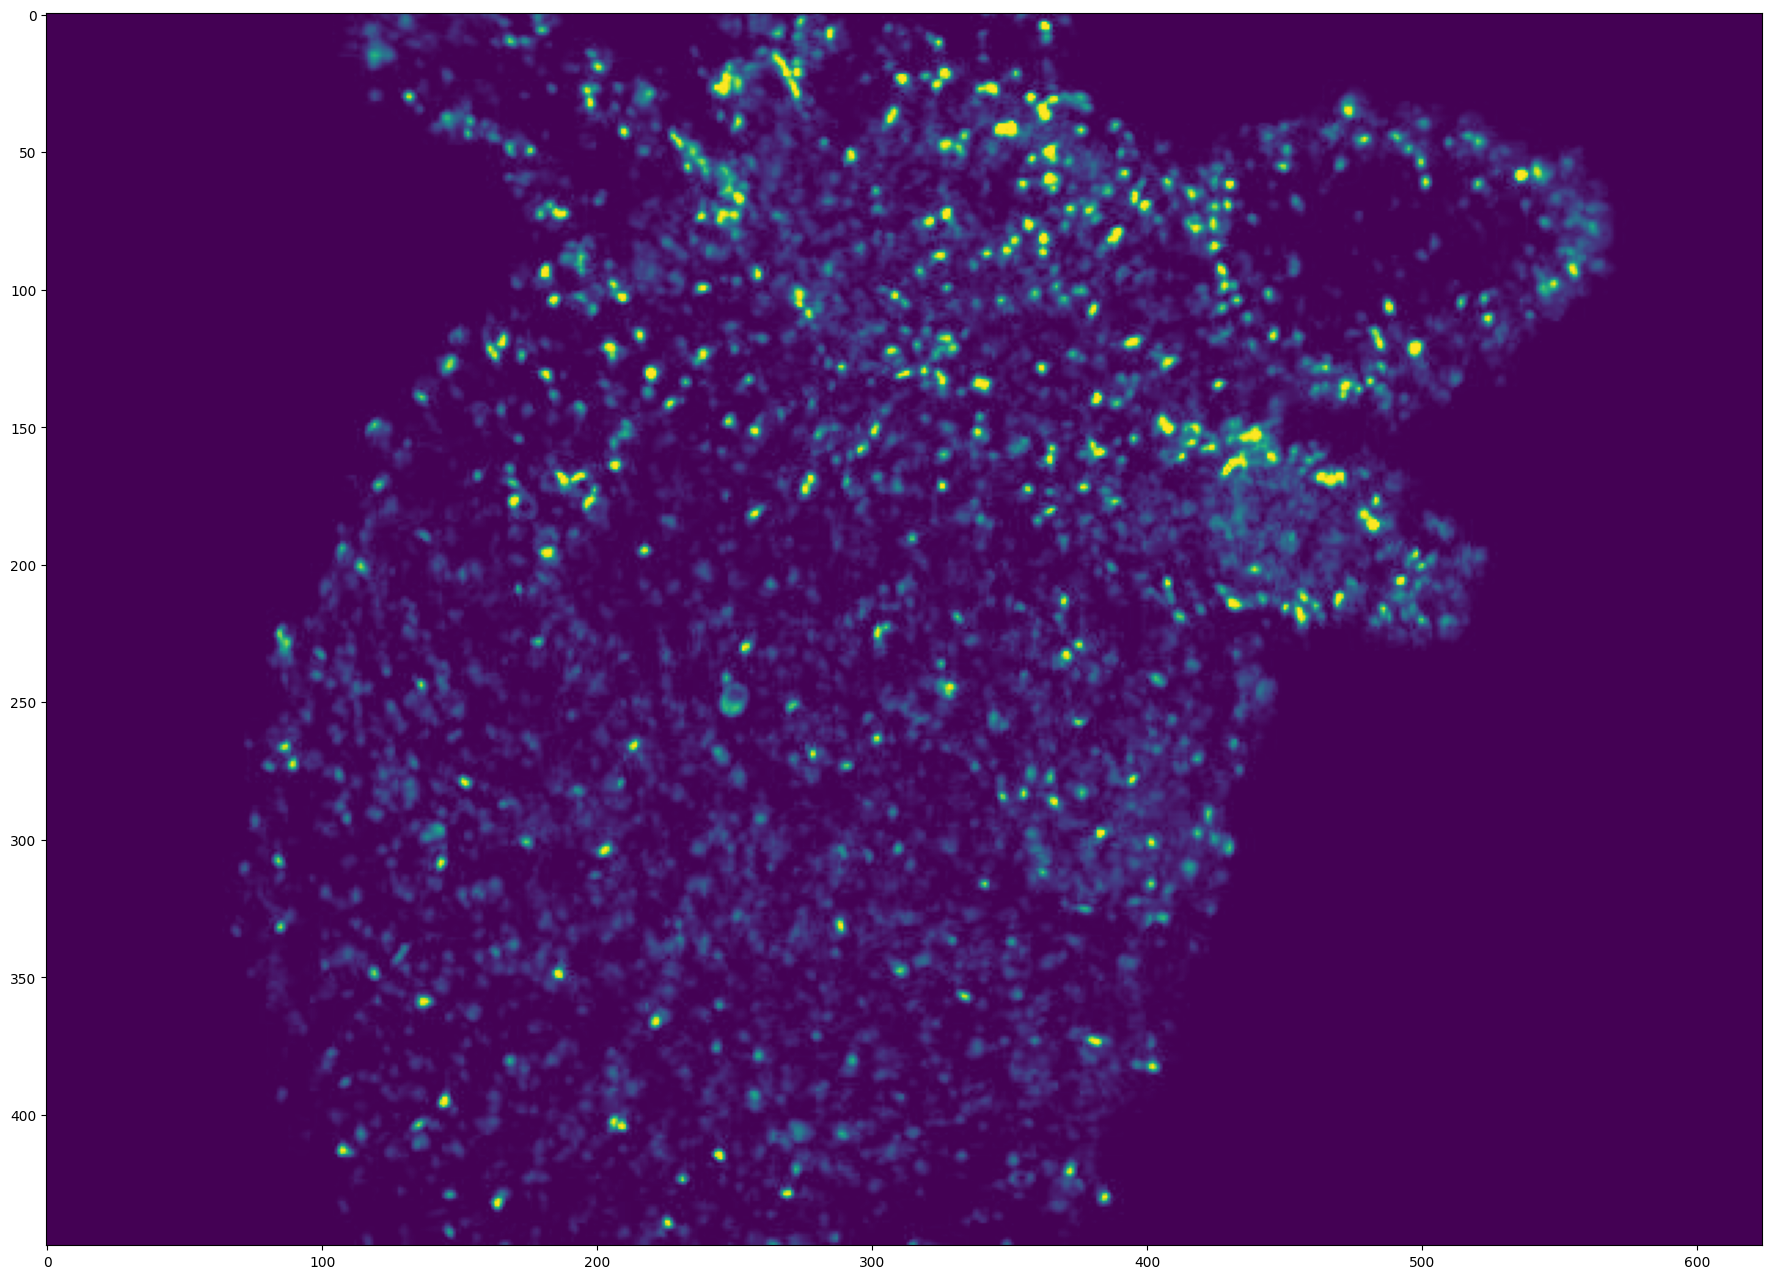

In [13]:
# Display the first frame of this sliced video

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(v[0])
plt.show()

In [14]:
# Compare with frame 150 of the original video

(v[0] == video[150][200:-200,200:-200]).all()

True

## Visualization

We provide an interactive visualization code to go through video, detections and tracks.
It was developped using open-cv and tested on Linux. Depending on the backend opencv uses, it may have different functionnalities (zooming, screenshots, ...)

In [15]:
# Display the video with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use v to switch on/off the display of the video

byotrack.visualize.InteractiveVisualizer(video).run()

In [16]:
# You can display a sliced video
# First focus on the 300 first frames, then go backward in time (5 frames at a time) and flip the vertical axis

byotrack.visualize.InteractiveVisualizer(video[:300][::-5, ::-1]).run()